<a href="https://colab.research.google.com/github/AzureAmber/STAT-390-Covid-Project/blob/main/Models/erica/lstm/Copy_of_6_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# These two lines avoid dead kernel after importing keras
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import keras

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from datetime import timedelta
import time as time
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('train_nn.csv', parse_dates = ['date'])
train = train.drop(['continent', 'G20', 'G24'], axis = 1)
test = pd.read_csv('test_nn.csv', parse_dates = ['date'])
test = test.drop(['continent', 'G20', 'G24'], axis = 1)

print(train.shape)
print(test.shape)

(24771, 34)
(5900, 34)


# Pre-processing

In [ ]:
# encode non-numeric features

days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train['day_of_week'] = train['day_of_week'].map(days)
test['day_of_week'] = test['day_of_week'].map(days)

indicator_columns = ['total_tests_b', 'new_tests_b', 'positive_rate_b', 'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']

# Convert indicator variables to numeric: True to 1 and False to 0
for col in indicator_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)


In [ ]:
# add one-wk lag for new_cases

def add_lagged_features(df, target, lag_periods):
    lagged_df = df[[target]].shift(lag_periods)
    lagged_df.columns = [f'lag{lag_periods}_' + target]
    existing_lagged_col = f'lag{lag_periods}_' + target
    if existing_lagged_col in df.columns:
        df = df.drop(columns=[existing_lagged_col])
    df_with_lags = df.join(lagged_df)
    return df_with_lags.fillna(0)

# Add one-week lag
train_with_1wk_lag = add_lagged_features(train, 'new_cases', 7)
test_with_1wk_lag = add_lagged_features(test, 'new_cases', 7)

# Add two-week lag
train_with_2wk_lag = add_lagged_features(train_with_1wk_lag, 'new_cases', 14)
test_with_2wk_lag = add_lagged_features(test_with_1wk_lag, 'new_cases', 14)

# Add one-month lag (approx 30 days)
train_with_1m_lag = add_lagged_features(train_with_2wk_lag, 'new_cases', 30)
test_with_1m_lag = add_lagged_features(test_with_2wk_lag, 'new_cases', 30)

In [ ]:
# normalize on country-level

def calculate_group_stats(df, group_col, cols_to_normalize):
    # Calculate mean and standard deviation for each column in each group
    group_stats = df.groupby(group_col)[cols_to_normalize].agg(['mean', 'std'])
    return group_stats

def normalize_with_group_stats(df, group_col, cols_to_normalize, group_stats):
    df_normalized = df.copy()
    for col in cols_to_normalize:
        # Normalize using group-specific statistics
        df_normalized[col] = df_normalized.groupby(group_col)[col].transform(
            lambda x: (x - group_stats.loc[x.name, (col, 'mean')]) / group_stats.loc[x.name, (col, 'std')]
        )
    df_normalized = df_normalized.fillna(0)
    return df_normalized


# List of indicator columns and non-numeric columns
indicators = ['total_tests_b', 'new_tests_b', 'positive_rate_b',
              'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']
non_numeric = ['date', 'location', 'day_of_week', 'month']

# Columns to normalize
numeric_cols = train_with_1m_lag.select_dtypes(include=['float64', 'int64']).columns
cols_to_normalize = numeric_cols.difference(['new_cases'] + indicators + non_numeric)

# Calculate stats from the training set for each country
group_stats = calculate_group_stats(train_with_1m_lag, 'location', cols_to_normalize)

# Normalize training and test sets using group-specific stats
train_normalized = normalize_with_group_stats(train_with_1m_lag, 'location', cols_to_normalize, group_stats)
test_normalized = normalize_with_group_stats(test_with_1m_lag, 'location', cols_to_normalize, group_stats)


#train_encoded = pd.get_dummies(train_normalized, columns=['location'])
#test_encoded = pd.get_dummies(test_normalized, columns=['location'])

In [ ]:
#Normalize response variable using min-max method from training set

# Select only US data from the normalized training and testing sets
US_train = train_normalized.loc[train_normalized['location'] == 'United States'].drop(columns = ['location'])
US_test = test_normalized.loc[test_normalized['location'] == 'United States'].drop(columns=['location'])

# Calculate min and max from training set
min_value = US_train['new_cases'].min()
max_value = US_train['new_cases'].max()

# Function to apply min-max normalization
def min_max_normalize(column, min_value, max_value):
    return (column - min_value) / (max_value - min_value)

# Apply normalization to training and testing sets
US_train['new_cases'] = min_max_normalize(US_train['new_cases'], min_value, max_value)
US_test['new_cases'] = min_max_normalize(US_test['new_cases'], min_value, max_value)


#combine train and test for US for make_series function
US_data=pd.concat([US_train, US_test])

#change index to date
US_data.set_index('date', inplace = True)

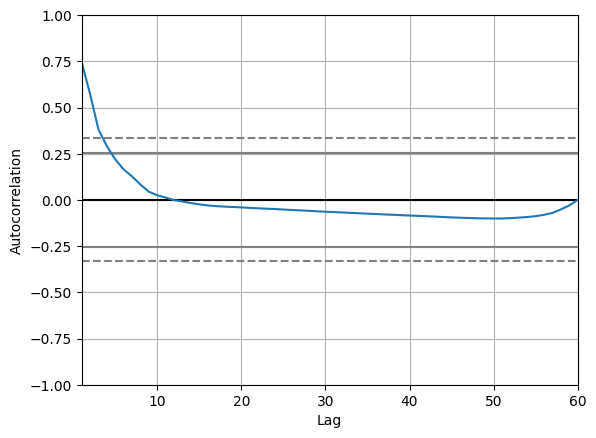

In [ ]:
# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(US_data['new_cases'].iloc[:60])
plt.show()

# 7 looks like a reasonable lag to capture weekly seasonality

In [ ]:
def make_series(data):
    series=[]
    for i in range(7, len(data)+1):
        subdf=data[(i-7):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop(['new_cases'], axis=1).values))
    return series

series=make_series(US_data)
print(series[0][0], series[0][1].shape, series[0][2].shape)
US_train = series[:(US_data.loc[US_data.index < '2023-01-01'].shape[0]-6)]
US_test = series[(US_data.loc[US_data.index < '2023-01-01'].shape[0]-6):]

2020-01-26 00:00:00 () (7, 34)


# Training

In [ ]:
def create_model(sequence_length, feature_size, learning_rate):

    inputs = Input(shape=(sequence_length, feature_size))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    return model

In [ ]:
# Create the LSTM model
lstm_model = create_model(7, 34, 0.05)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 34)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8576      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 8609 (33.63 KB)
Trainable params: 8609 (33.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
np.random.seed(42)

x=np.array([x[2].reshape(7,34)for x in US_train])
y=np.array([x[1] for x in US_train])

print(x.shape)
print(y.shape)

history = lstm_model.fit(
    x=x,y=y,
    epochs= 100,
    batch_size= 64,
    shuffle=False,
)

(1071, 7, 34)
(1071,)
Epoch 1/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 11/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 12/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 13/100
17

In [ ]:
US_train_pred = pd.DataFrame(lstm_model.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_pred = pd.DataFrame(lstm_model.predict(np.array([x[2].reshape(7,34) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test])

US_train_pred = (US_train_pred * (max_value - min_value)) + min_value
US_test_pred = (US_test_pred * (max_value - min_value)) + min_value

8/8 [==============================] - 0s 2ms/step


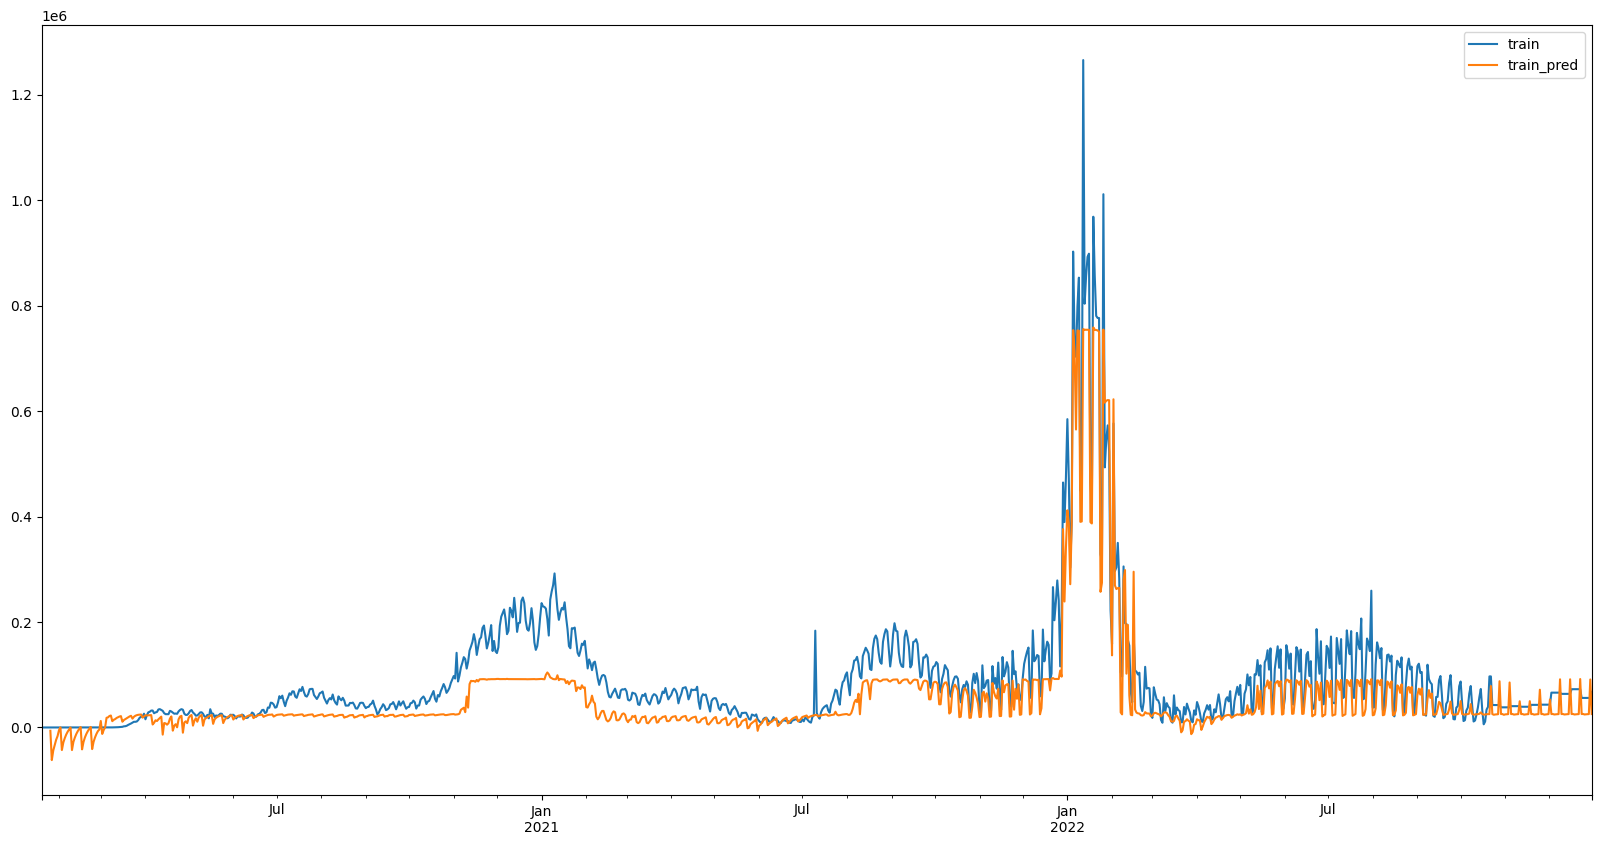

In [ ]:
# plotting the training data
y_train_actual = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual, US_train_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

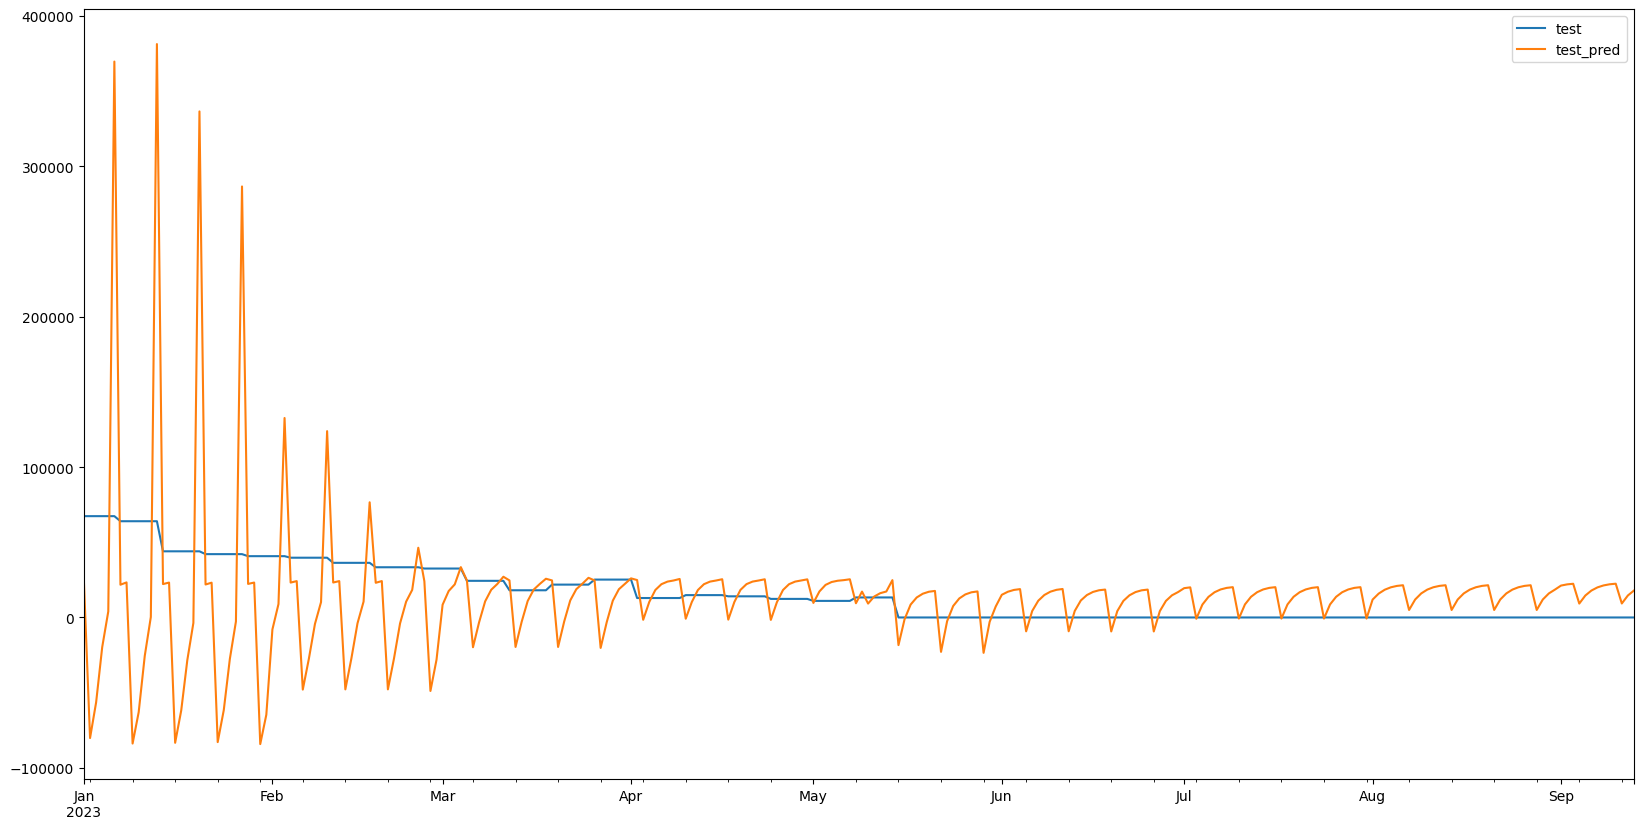

In [ ]:
# plottting the testing data
y_test_actual = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual, US_test_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [ ]:
print("The rmse on the US training data is", sqrt(mean_squared_error(y_train_actual[6:], US_train_pred['yhat'], squared = True)))
print("The rmse on the US testing data is", sqrt(mean_squared_error(y_test_actual, US_test_pred['yhat'], squared = True)))

The rmse on the US training data is 54676.82984100953
The rmse on the US testing data is 50710.886531702934


It seems to fit training data ok - it's able to catch the peak in 2022 - and even better for testing data. We have a lower testing RMSE than training RMSE. So we will now tune the hyperparameter to see if model performance can be improved.


# Tuning Hyperparameters

In [ ]:
import itertools

learning_rate = [0.01, 0.02, 0.05]
epochs = [100, 200, 300]
batch_size =[16, 32, 64]
combination = list(itertools.product(learning_rate, epochs, batch_size))

x=np.array([x[2].reshape(7,34) for x in US_train])
y=np.array([x[1] for x in US_train])

In [ ]:
np.random.seed(42)

rmse_list = []
combination_list = []

tscv = TimeSeriesSplit(n_splits=5)

for comb in combination:
    learning_rate, epochs, batch_size = comb
    rmse_scores = []

    for train_index, val_index in tscv.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Initialize model
        inputs = Input(shape=(7,34))
        lstm_out = LSTM(32)(inputs)
        outputs = Dense(1)(lstm_out)
        model_tuned = Model(inputs=inputs, outputs=outputs)
        model_tuned.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

        # Fit the model on the training fold
        model_tuned.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=0)

        # Predict on the validation fold
        y_pred = model_tuned.predict(x_val)

        # Calculate RMSE for the current fold and add to the list
        rmse = sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Calculate average RMSE for this combination
    average_rmse = np.mean(rmse_scores)
    rmse_list.append(average_rmse)
    combination_list.append(comb)
    print(f"Completed: {comb} with Avg RMSE: {average_rmse}")

# Finding the best hyperparameter combination
best_combination_index = np.argmin(rmse_list)
best_hyperparameters = combination_list[best_combination_index]
best_rmse = rmse_list[best_combination_index]

print(f"Best Hyperparameters: {best_hyperparameters} with RMSE: {best_rmse}")

6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 100, 16) with Avg RMSE: 0.07896546409422116
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 100, 32) with Avg RMSE: 0.041245497123410024
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 100, 64) with Avg RMSE: 0.06704556904158852
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 200, 16) with Avg RMSE: 0.051803754743817286
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 200, 32) with Avg RMSE: 0.04386360291888355
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 200, 64) with Avg RMSE: 0.04248668981138797
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 300, 16) with Avg RMSE: 0.04956884267746734
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 300, 32) with Avg RMSE: 0.05883282815406132
6/6 [==============================] - 0s 2ms/step
Completed: (0.01, 300, 64) with Avg RMSE: 0

In [ ]:
# tuned model
learning_rate = 0.05
batch_size = 64
epochs = 100
sequence_length = 7
inputs = Input(shape=(7,34))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)
model_best = Model(inputs=inputs, outputs=outputs)
model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
x=np.array([x[2].reshape(7,34) for x in US_train])
y=np.array([x[1] for x in US_train])
print(x.shape)
print(y.shape)
history_best = model_best.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
)


(1071, 7, 34)
(1071,)
Epoch 1/100
17/17 [==============================] - 2s 4ms/step - loss: 0.4616
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.2506
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0355
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0429
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0399
Epoch 11/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 12/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 13/100
17

In [ ]:
US_train_best_pred = pd.DataFrame(model_best.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_best_pred = pd.DataFrame(model_best.predict(np.array([x[2].reshape(7,34) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test ])

US_train_best_pred = (US_train_best_pred * (max_value - min_value)) + min_value
US_test_best_pred = (US_test_best_pred * (max_value - min_value)) + min_value

8/8 [==============================] - 0s 2ms/step


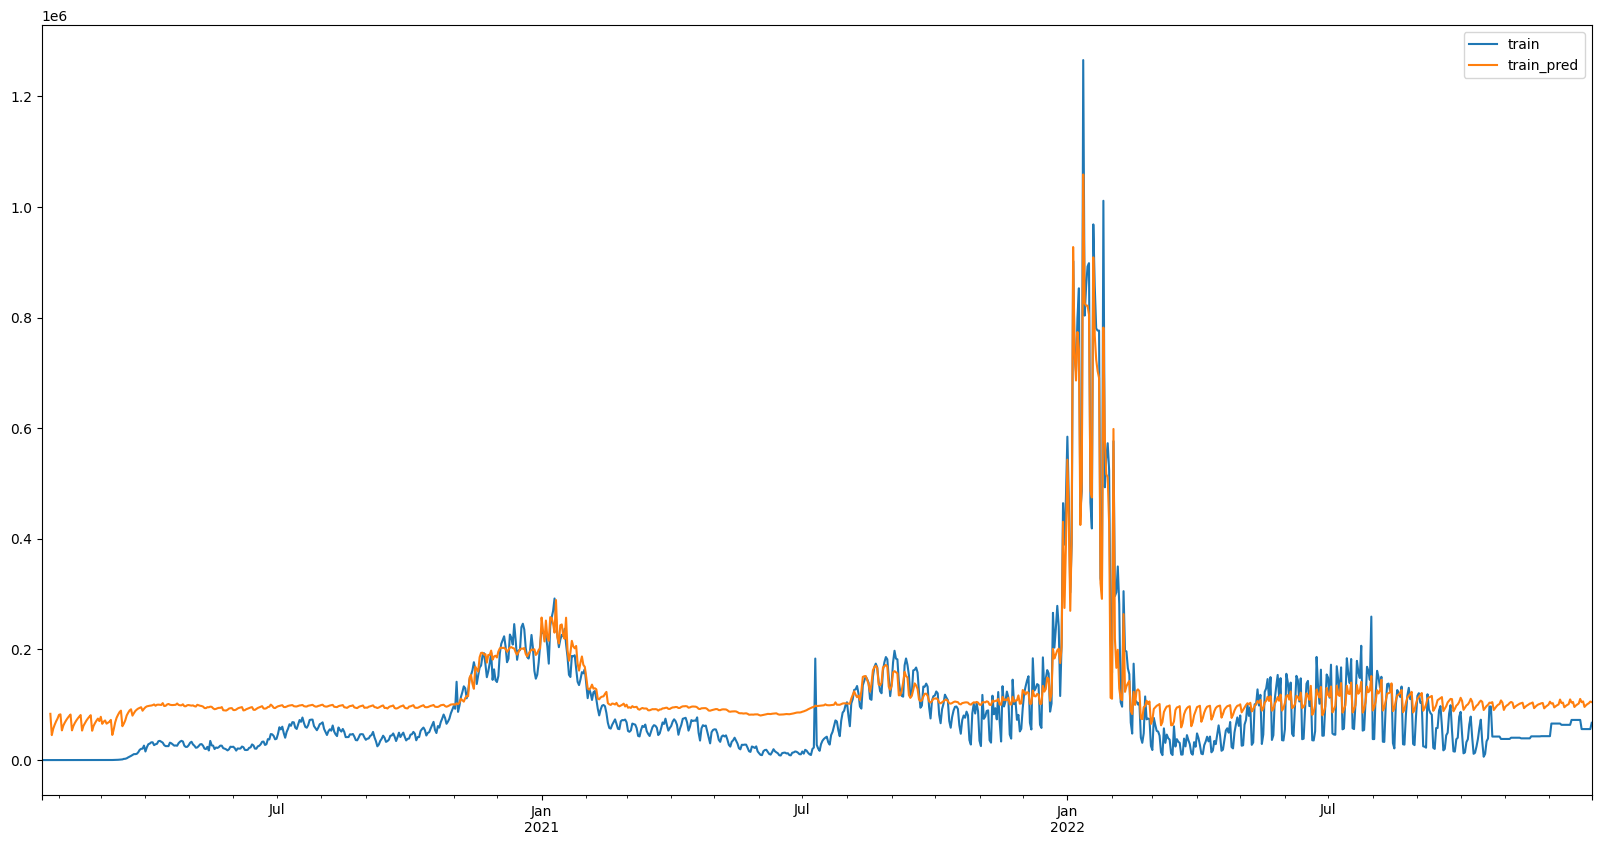

In [ ]:
# plotting the training data

y_train_actual_best = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual_best.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual_best, US_train_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])
plt.savefig('US_training_data_plot.jpeg')


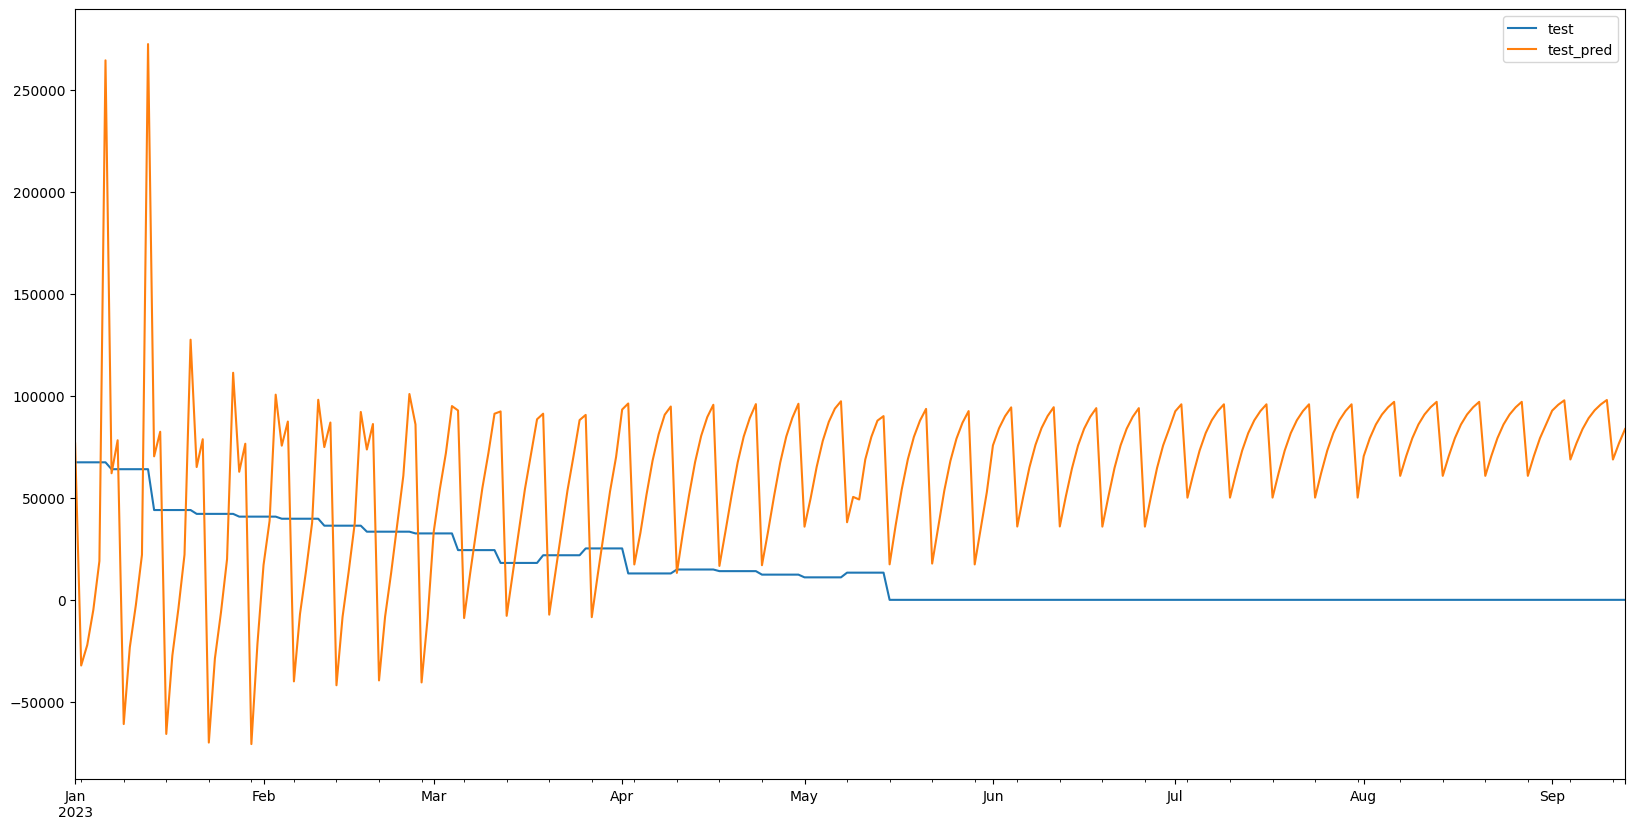

In [ ]:
# plottting the testing data
y_test_actual_best = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual_best.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual_best, US_test_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])
plt.savefig('US_testing_data_plot.jpeg')

In [ ]:
print("The rmse on the US training data is", sqrt(mean_squared_error(y_train_actual_best[6:], US_train_best_pred['yhat'], squared = True)))
print("The rmse on the US testing data is", sqrt(mean_squared_error(y_test_actual_best, US_test_best_pred['yhat'], squared = True)))

The rmse on the US training data is 50104.32083165978
The rmse on the US testing data is 69074.08233029724


Overfitting training data but still not too bad result - slight improvement from manual combo. If have time, should try log transform y rather than normalize it.

# Fitting whole dataset

In [ ]:
# define make series again
def make_series(data):
    series=[]
    for i in range(7, len(data)+1):
        subdf=data[(i-7):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop('new_cases', axis=1).values))
    return series

In [ ]:
rmse_results = []
loc_list = list(train_normalized.location.unique())

for loc in loc_list:

    loc_data = data[data['location'] == loc]
    loc_data = data.loc[data.location == loc].drop(columns = ['location']).astype(float)

    #normalize target variable
    min_value = loc_data['new_cases'].min()
    max_value = loc_data['new_cases'].max()
    loc_data['new_cases'] = (loc_data['new_cases'] - min_value) / (max_value - min_value)

    #feed into series
    series=make_series(loc_data)
    loc_train = series[:(loc_data.loc[loc_data.index < '2023-01-01'].shape[0]-13)]
    loc_test = series[(loc_data.loc[loc_data.index < '2023-01-01'].shape[0]-13):]

    #fit the model
    learning_rate = 0.01
    batch_size = 16
    epochs = 100
    sequence_length = 14
    inputs = Input(shape=(14,32))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model2 = Model(inputs=inputs, outputs=outputs)
    model2.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    x=np.array([x[2].reshape(14,32) for x in loc_train])
    y=np.array([x[1] for x in loc_train])
    history2 = model2.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False)

    #predict train and test

    loc_train_pred = pd.DataFrame(model2.predict(x), columns=['yhat'], index=[x[0] for x in loc_train])
    loc_test_pred = pd.DataFrame(model2.predict(np.array([x[2].reshape(14,32) for x in loc_test])), columns=['yhat'], index=[x[0] for x in loc_test ])

    #denormalize train and test
    loc_train_pred = (loc_train_pred * (max_value - min_value)) + min_value
    loc_test_pred = (loc_test_pred * (max_value - min_value)) + min_value


    y_train2 = train_normalized.loc[train_normalized.location == loc, 'new_cases']
    y_train2.index = train_normalized.loc[train_normalized.location == loc, 'date']

    y_test2 = test_normalized.loc[test_normalized.location == loc, 'new_cases']
    y_test2.index = test_normalized.loc[test_normalized.location == loc, 'date']

    #calculate rmse

    train_rmse = mean_squared_error(y_train2[13:], loc_train_pred['yhat'], squared=False)
    test_rmse = mean_squared_error(y_test2, loc_test_pred['yhat'], squared=False)
    print(f"The RMSE on the {loc} training data is {train_rmse}")
    print(f"The RMSE on the {loc} testing data is {test_rmse}")

    # Append RMSE results to the list
    rmse_results.append([loc, train_rmse, test_rmse])

    # Plotting the training data
    train_plot = pd.concat([y_train2, loc_train_pred['yhat']], axis=1)
    train_plot.plot(figsize=(20,10))
    plt.legend(['train', 'train_pred'])
    plt.title(f"{loc} - Training Data")
    plt.savefig(f'{loc}_training_data_plot.jpeg')

    # Plotting the testing data
    test_plot = pd.concat([y_test2, loc_test_pred['yhat']], axis=1)
    test_plot.plot(figsize=(20,10))
    plt.legend(['test', 'test_pred'])
    plt.title(f"{loc} - Testing Data")
    plt.savefig(f'{loc}_testing_data_plot.jpeg')


In [ ]:
# Convert RMSE results to a DataFrame and save as CSV
rmse_df = pd.DataFrame(rmse_results, columns=['Location', 'Train RMSE', 'Test RMSE'])
rmse_df.to_csv('lstm_rmse_results.csv', index=False)